1. Incarcare librarii si date

In [27]:
# Librarii de baza
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
import joblib

# Incarcare dataset
df = pd.read_csv('data/IMLP4_TASK_03-products.csv')
df.head()


,product ID,Product Title,Merchant ID,Category Label,_Product Code,Number_of_Views,Merchant Rating,Listing Date
0,1,apple iphone 8 plus 64gb silver,1,Mobile Phones,QA-2276-XC,860.0,2.5,5/10/2024
1,2,apple iphone 8 plus 64 gb spacegrau,2,Mobile Phones,KA-2501-QO,3772.0,4.8,12/31/2024
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,Mobile Phones,FP-8086-IE,3092.0,3.9,11/10/2024
3,4,apple iphone 8 plus 64gb space grey,4,Mobile Phones,YI-0086-US,466.0,3.4,5/2/2022
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,Mobile Phones,NZ-3586-WP,4426.0,1.6,4/12/2023


2. Explorarea initiala a datelor

In [28]:
# Forma dataset
print("Shape:", df.shape)

# Tipuri si valori lipsa
print(df.info())

# Statistici sumare pentru coloanele numerice
print(df.describe())

# Verificare valori duplicate
print("Duplicated rows:", df.duplicated().sum())


Shape: (35311, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product ID       35311 non-null  int64  
 1   Product Title    35139 non-null  object 
 2   Merchant ID      35311 non-null  int64  
 3    Category Label  35267 non-null  object 
 4   _Product Code    35216 non-null  object 
 5   Number_of_Views  35297 non-null  float64
 6   Merchant Rating  35141 non-null  float64
 7    Listing Date    35252 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.2+ MB
None
         product ID   Merchant ID  Number_of_Views  Merchant Rating
count  35311.000000  35311.000000     35297.000000     35141.000000
mean   26150.800176    120.501883      2501.469587         2.998261
std    13498.191220    117.045557      1438.217697         1.152664
min        1.000000      1.000000         0.000000         1.000000
25%    

3. Curatarea si normalizarea datelor

In [29]:
# Functie de normalizare coloane
def normalize_column_name(col_name):
    col_name = col_name.strip().lower()
    col_name = ''.join(c if c.isalnum() else '_' for c in col_name)
    while '__' in col_name:
        col_name = col_name.replace('__', '_')
    return col_name.strip('_')

df.columns = [normalize_column_name(c) for c in df.columns]

# Eliminare valori lipsa si duplicate
df = df.dropna().drop_duplicates()

# Curatare text 'product_title'
df['product_title'] = df['product_title'].astype(str).str.strip().str.lower()
df['product_title'] = df['product_title'].apply(lambda x: re.sub(r'[^a-z0-9\s]', ' ', x))

# Corectare etichete
df['category_label'] = df['category_label'].replace({
    'Mobile Phone': 'Mobile Phones',
    'fridge': 'Fridges',
    'CPU': 'CPUs'
})

df.head()


,product_id,product_title,merchant_id,category_label,product_code,number_of_views,merchant_rating,listing_date
0,1,apple iphone 8 plus 64gb silver,1,Mobile Phones,QA-2276-XC,860.0,2.5,5/10/2024
1,2,apple iphone 8 plus 64 gb spacegrau,2,Mobile Phones,KA-2501-QO,3772.0,4.8,12/31/2024
2,3,apple mq8n2b a iphone 8 plus 64gb 5 5 12mp sim...,3,Mobile Phones,FP-8086-IE,3092.0,3.9,11/10/2024
3,4,apple iphone 8 plus 64gb space grey,4,Mobile Phones,YI-0086-US,466.0,3.4,5/2/2022
4,5,apple iphone 8 plus gold 5 5 64gb 4g unlocked ...,5,Mobile Phones,NZ-3586-WP,4426.0,1.6,4/12/2023


4. Analiza exploratorie (EDA)

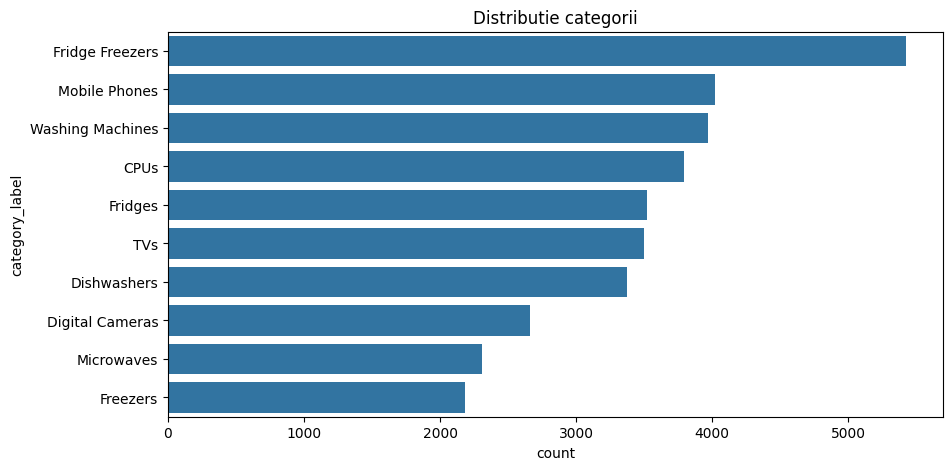

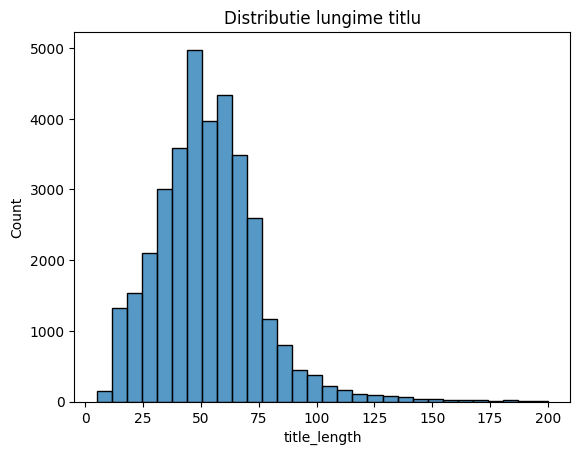

In [30]:
# Distributie categorii
plt.figure(figsize=(10,5))
sns.countplot(y='category_label', data=df, order=df['category_label'].value_counts().index)
plt.title("Distributie categorii")
plt.show()

# Lungimea titlurilor
df['title_length'] = df['product_title'].apply(len)
sns.histplot(df['title_length'], bins=30)
plt.title("Distributie lungime titlu")
plt.show()


5. Impartirea datasetului in train si test

In [31]:
X = df['product_title']
y = df['category_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


6. Definire modele si cross-validation

In [32]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Linear SVC": LinearSVC()
}

results = {}
for name, model in models.items():
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ("clf", model)
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
    results[name] = (scores.mean(), scores.std())

for model, (mean_acc, std_acc) in results.items():
    print(f"{model}: {mean_acc:.4f} (+/- {std_acc:.4f})")


Logistic Regression: 0.9507 (+/- 0.0041)
Naive Bayes: 0.9330 (+/- 0.0029)
Random Forest: 0.9501 (+/- 0.0043)
Linear SVC: 0.9526 (+/- 0.0054)


7. Antrenarea modelului final

In [33]:
final_model = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ("clf", LinearSVC())
])

final_model.fit(X_train, y_train)

# Evaluare pe setul de test
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))


                  precision    recall  f1-score   support

            CPUs       1.00      1.00      1.00       758
 Digital Cameras       0.99      0.99      0.99       532
     Dishwashers       0.90      0.97      0.93       675
        Freezers       0.93      0.91      0.92       436
 Fridge Freezers       0.93      0.92      0.93      1085
         Fridges       0.93      0.85      0.89       705
      Microwaves       0.97      0.96      0.96       461
   Mobile Phones       0.99      0.99      0.99       805
             TVs       0.96      1.00      0.98       701
Washing Machines       0.93      0.95      0.94       794

        accuracy                           0.95      6952
       macro avg       0.95      0.95      0.95      6952
    weighted avg       0.95      0.95      0.95      6952



8. Salvarea modelului

In [34]:
joblib.dump(final_model, "final_product_classifier.pkl")
print("Modelul final a fost salvat in 'final_product_classifier.pkl'")


Modelul final a fost salvat in 'final_product_classifier.pkl'


9. Testare predictii

In [35]:
# Predictie simpla
def predict_one(title):
    return final_model.predict([title])[0]

test_title = "Samsung Galaxy S23"
print("Predicted category:", predict_one(test_title))


Predicted category: Mobile Phones
